# Visualizing Barren Plateaus

[References](https://github.com/Gopal-Dahale/ILearnQuantum/blob/main/layerwise_learning_with_qiskit_and_pytorch/barren_plateaus_visualization.ipynb)

In [10]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
import os
from qiskit.primitives import Estimator

seed = 42
np.random.seed(seed)

In [11]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch import nn
import pandas as pd

from sklearn.decomposition import PCA

from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.log_ops import *
from Components.utils import *

In [12]:
surface0 = pd.read_csv('Logs-Cancer-v4/m0/LossFunctionSurface.csv', index_col=0)
path0 = pd.read_csv('Logs-Cancer-v4/m0/m0-0-Weights.csv', index_col=0)
path0[path0.shape[1]] = pd.read_csv('Logs-Cancer-v4/m0/m0-0-LossFunction.csv', index_col=0)
surface0.reset_index(drop=True, inplace=True)
path0.reset_index(drop=True, inplace=True)

surface1 = pd.read_csv('Logs-Cancer-v4/m1/LossFunctionSurface.csv', index_col=0)
path1 = pd.read_csv('Logs-Cancer-v4/m1/m1-0-Weights.csv', index_col=0)
path1[path1.shape[1]] = pd.read_csv('Logs-Cancer-v4/m1/m1-0-LossFunction.csv', index_col=0)

surface2 = pd.read_csv('Logs-Cancer-v4/m2/LossFunctionSurface.csv', index_col=0)
path2 = pd.read_csv('Logs-Cancer-v4/m2/m2-0-Weights.csv', index_col=0)
path2[path2.shape[1]] = pd.read_csv('Logs-Cancer-v4/m2/m2-0-LossFunction.csv', index_col=0)

surface3 = pd.read_csv('Logs-Cancer-v4/m3/LossFunctionSurface.csv', index_col=0)
path3 = pd.read_csv('Logs-Cancer-v4/m3/m3-0-Weights.csv', index_col=0)
path3[path3.shape[1]] = pd.read_csv('Logs-Cancer-v4/m3/m3-0-LossFunction.csv', index_col=0)

In [13]:
path0

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,-0.530536,-0.837592,-0.305775,0.796407,0.370287,-0.232307,-0.034159,-0.049541,0.751379,-0.879670,...,0.575733,0.119622,-0.698951,0.259170,-0.744711,0.207939,-0.417988,-0.384596,-0.937752,1.018288
1,-0.583358,-0.890414,-0.358597,0.743585,0.423110,-0.285130,-0.086982,-0.102363,0.804202,-0.826848,...,0.522912,0.066799,-0.646128,0.311993,-0.691889,0.260762,-0.365166,-0.331773,-0.884929,0.960503
2,-0.613474,-0.941924,-0.309149,0.702996,0.463977,-0.333037,-0.096288,-0.116224,0.828580,-0.775464,...,0.575073,0.115924,-0.612565,0.336182,-0.668285,0.297015,-0.415431,-0.289523,-0.854640,0.917773
3,-0.623331,-0.988533,-0.356880,0.671280,0.499596,-0.345974,-0.076833,-0.110888,0.841581,-0.741315,...,0.610411,0.096362,-0.578189,0.366637,-0.654062,0.331379,-0.456145,-0.254444,-0.823716,0.882829
4,-0.615341,-1.021625,-0.405267,0.641705,0.521800,-0.339472,-0.040089,-0.080534,0.836569,-0.781656,...,0.620189,0.145376,-0.545641,0.393897,-0.635870,0.359984,-0.486935,-0.229467,-0.801752,0.857263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.471029,-0.885800,-0.741935,0.538605,0.424141,-0.412488,0.377207,0.341384,0.909568,-1.295347,...,0.591719,0.548804,-0.583782,0.568733,-0.341091,0.328397,-0.619389,0.298644,-0.781400,0.708585
96,-0.495629,-0.839529,-0.729051,0.545882,0.442275,-0.426545,0.413025,0.322612,0.921603,-1.340951,...,0.602020,0.549580,-0.580184,0.583070,-0.366048,0.347074,-0.587386,0.270985,-0.740996,0.708469
97,-0.469560,-0.882954,-0.739249,0.543184,0.421444,-0.413708,0.370222,0.349414,0.905637,-1.297141,...,0.587792,0.548260,-0.591747,0.570199,-0.343147,0.319699,-0.622628,0.294678,-0.778786,0.708376
98,-0.495393,-0.839473,-0.720756,0.548235,0.439666,-0.429446,0.405166,0.330428,0.920263,-1.343232,...,0.602949,0.551375,-0.584571,0.582763,-0.364450,0.340255,-0.592585,0.271217,-0.740444,0.708247


In [14]:
df = pd.concat([surface0, path0], ).astype(float)


In [15]:
df

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,104
0,1.477900,0.100346,0.375250,0.134959,0.022718,0.595012,0.164538,0.492884,0.243788,0.746224,...,1.457389,1.077737,0.809590,1.027489,0.395726,1.129187,0.415940,1.552553,1.030014,NaN
1,1.316149,0.132265,0.412425,0.112343,-0.011830,0.589759,0.150464,0.438073,0.107651,0.593111,...,1.457453,0.912828,0.896715,1.013738,0.393161,0.994645,0.406288,1.586538,1.021274,NaN
2,1.486004,0.086572,0.483208,0.150592,-0.002276,0.684890,0.232439,0.481620,0.152090,0.717363,...,1.414147,1.026968,0.861158,1.053797,0.420461,0.985881,0.460993,1.436422,1.016763,NaN
3,1.459259,0.103541,0.492211,0.013855,-0.075201,0.523598,0.121701,0.382505,0.142766,0.598408,...,1.390808,1.069284,0.954125,1.210604,0.365902,1.155853,0.529217,1.598872,1.012501,NaN
4,1.405709,0.059184,0.374840,0.158974,-0.072008,0.532856,0.101546,0.493118,0.070732,0.712818,...,1.556777,1.044696,0.821620,1.194870,0.395513,0.990098,0.537950,1.440259,1.035691,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.471029,-0.885800,-0.741935,0.538605,0.424141,-0.412488,0.377207,0.341384,0.909568,-1.295347,...,0.548804,-0.583782,0.568733,-0.341091,0.328397,-0.619389,0.298644,-0.781400,NaN,0.708585
96,-0.495629,-0.839529,-0.729051,0.545882,0.442275,-0.426545,0.413025,0.322612,0.921603,-1.340951,...,0.549580,-0.580184,0.583070,-0.366048,0.347074,-0.587386,0.270985,-0.740996,NaN,0.708469
97,-0.469560,-0.882954,-0.739249,0.543184,0.421444,-0.413708,0.370222,0.349414,0.905637,-1.297141,...,0.548260,-0.591747,0.570199,-0.343147,0.319699,-0.622628,0.294678,-0.778786,NaN,0.708376
98,-0.495393,-0.839473,-0.720756,0.548235,0.439666,-0.429446,0.405166,0.330428,0.920263,-1.343232,...,0.551375,-0.584571,0.582763,-0.364450,0.340255,-0.592585,0.271217,-0.740444,NaN,0.708247


In [16]:
df

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,104
0,1.477900,0.100346,0.375250,0.134959,0.022718,0.595012,0.164538,0.492884,0.243788,0.746224,...,1.457389,1.077737,0.809590,1.027489,0.395726,1.129187,0.415940,1.552553,1.030014,NaN
1,1.316149,0.132265,0.412425,0.112343,-0.011830,0.589759,0.150464,0.438073,0.107651,0.593111,...,1.457453,0.912828,0.896715,1.013738,0.393161,0.994645,0.406288,1.586538,1.021274,NaN
2,1.486004,0.086572,0.483208,0.150592,-0.002276,0.684890,0.232439,0.481620,0.152090,0.717363,...,1.414147,1.026968,0.861158,1.053797,0.420461,0.985881,0.460993,1.436422,1.016763,NaN
3,1.459259,0.103541,0.492211,0.013855,-0.075201,0.523598,0.121701,0.382505,0.142766,0.598408,...,1.390808,1.069284,0.954125,1.210604,0.365902,1.155853,0.529217,1.598872,1.012501,NaN
4,1.405709,0.059184,0.374840,0.158974,-0.072008,0.532856,0.101546,0.493118,0.070732,0.712818,...,1.556777,1.044696,0.821620,1.194870,0.395513,0.990098,0.537950,1.440259,1.035691,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.471029,-0.885800,-0.741935,0.538605,0.424141,-0.412488,0.377207,0.341384,0.909568,-1.295347,...,0.548804,-0.583782,0.568733,-0.341091,0.328397,-0.619389,0.298644,-0.781400,NaN,0.708585
96,-0.495629,-0.839529,-0.729051,0.545882,0.442275,-0.426545,0.413025,0.322612,0.921603,-1.340951,...,0.549580,-0.580184,0.583070,-0.366048,0.347074,-0.587386,0.270985,-0.740996,NaN,0.708469
97,-0.469560,-0.882954,-0.739249,0.543184,0.421444,-0.413708,0.370222,0.349414,0.905637,-1.297141,...,0.548260,-0.591747,0.570199,-0.343147,0.319699,-0.622628,0.294678,-0.778786,NaN,0.708376
98,-0.495393,-0.839473,-0.720756,0.548235,0.439666,-0.429446,0.405166,0.330428,0.920263,-1.343232,...,0.551375,-0.584571,0.582763,-0.364450,0.340255,-0.592585,0.271217,-0.740444,NaN,0.708247


In [17]:
def plot_surface(surface:pd.DataFrame, path=None, title = None, dpi = 80):
    '''
    use %matplotlib widget for interative plot!
    '''
    if path is not None:
        data = pd.concat([surface, path], ignore_index=True)
    else:
        data = surface
    print(f'Check NaN: {data.isnull().values.any()}')

    parameters = data.iloc[:,:-1]
    zValue = data.iloc[:,-1]

    pca = PCA(n_components=2)
    pca.fit(parameters)
    principalSurfaceData = pca.transform(surface.iloc[:,:-1])

    print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
    principalSurfaceDataDF = pd.DataFrame(principalSurfaceData, columns=['x', 'y'])
    principalSurfaceDataDF['z'] = surface.iloc[:,-1]

    from mpl_toolkits.mplot3d import Axes3D
    surfaceXs = principalSurfaceDataDF['x'][:surface.shape[0]]
    surfaceYs = principalSurfaceDataDF['y'][:surface.shape[0]]
    surfaceZs = principalSurfaceDataDF['z'][:surface.shape[0]]

    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('Params PC1')
    ax.set_ylabel('Params PC2')
    ax.set_zlabel('Means Absolute Error')

    if title:
        ax.set_title(title)

    plot = ax.plot_trisurf(surfaceXs,
                       surfaceYs,
                       surfaceZs,
                       cmap=plt.get_cmap('rainbow'),
                       linewidth=1,
                       antialiased=False,
                       alpha=0.6)
    
    plt.colorbar(plot, shrink=0.5, aspect=5)

    if path is not None:
        pathParameters = path.iloc[:,:-1]
        pathZValue = pathParameters.iloc[:,-1]

        principalPathData = pca.transform(pathParameters)
        principalPathDataDF = pd.DataFrame(principalPathData, columns=['x', 'y'])
        principalPathDataDF['z'] = pathZValue
        
        ax.plot3D(principalPathDataDF['x'],
                principalPathDataDF['y'],
                principalPathDataDF['z'],
                # cmap=plt.get_cmap('rainbow'),
                linewidth=1,
                antialiased=False,
                alpha=1)



    plt.show()
    

Check NaN: False
Explained Variance Ratio: [0.02637827 0.02590188]


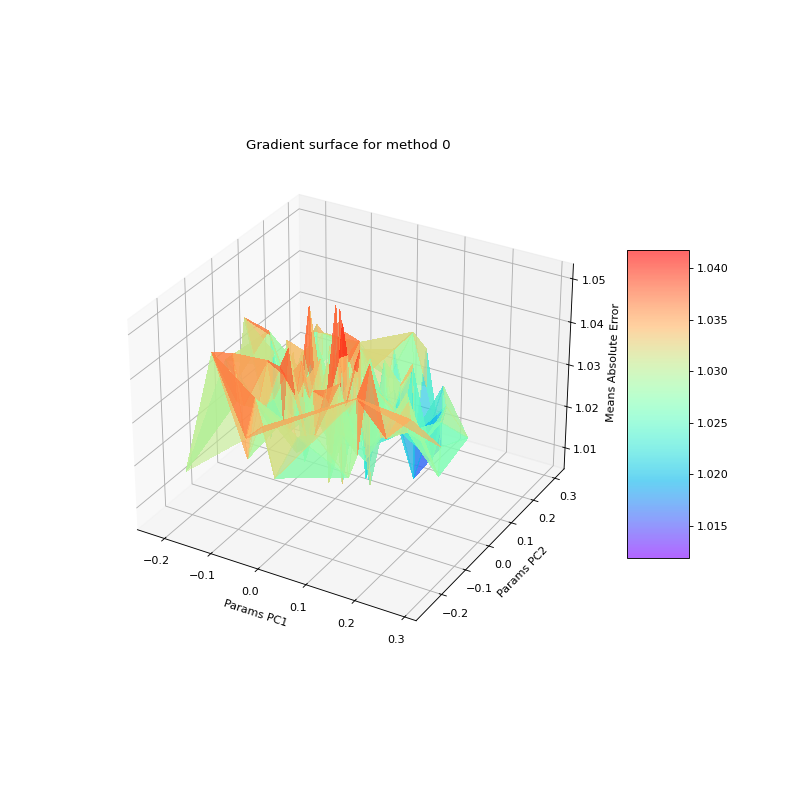

In [19]:
%matplotlib widget
plot_surface(surface0, title='Gradient surface for method 0')

Check NaN: False
Explained Variance Ratio: [0.07179541 0.06692732]


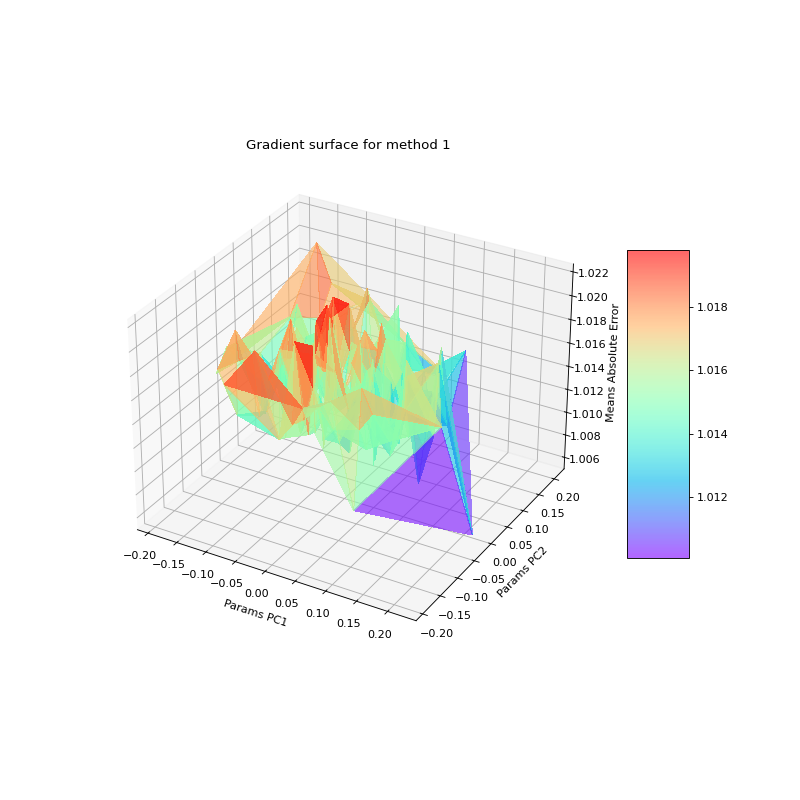

In [20]:
%matplotlib widget
plot_surface(surface1, title='Gradient surface for method 1')

Check NaN: False
Explained Variance Ratio: [0.02892266 0.02581112]


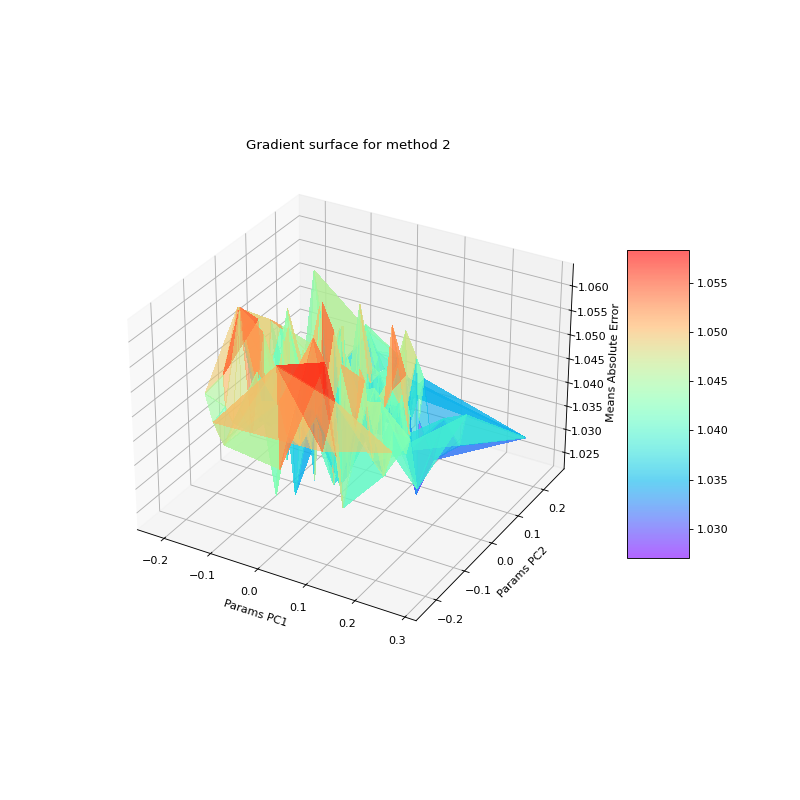

In [21]:
%matplotlib widget
plot_surface(surface2, title='Gradient surface for method 2')

Check NaN: False
Explained Variance Ratio: [0.02604273 0.02515472]


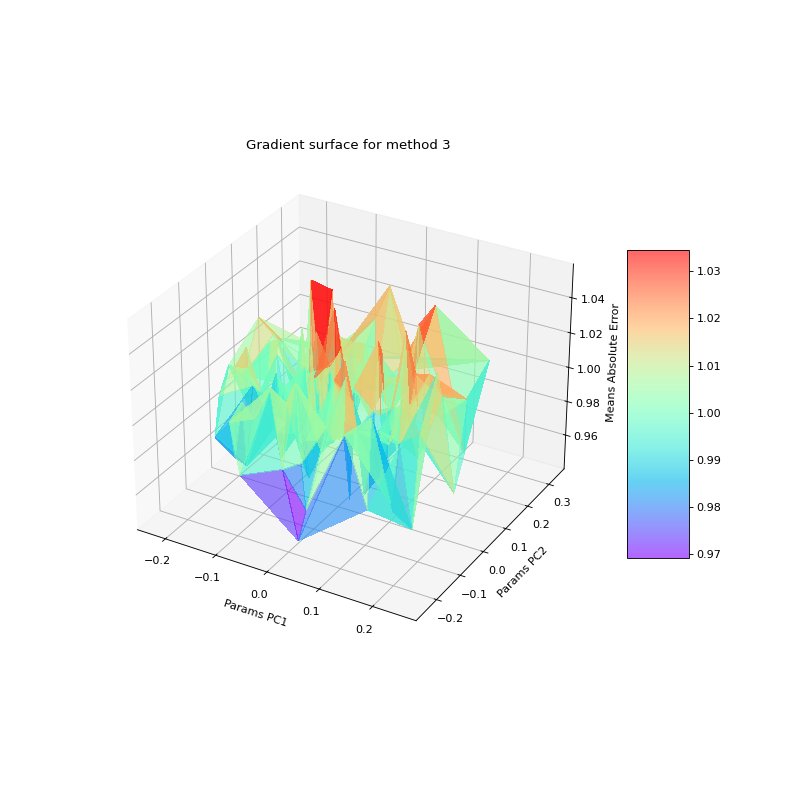

In [22]:
%matplotlib widget
plot_surface(surface3, title='Gradient surface for method 3')